# Challenge Data Scientist - Wen Li

The goal of this project is to predict the probability of delay of the flights that land or take off from the airport of Santiago de Chile (SCL). For that we have a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL during 2017.

## 0.0 Package Import and Global variables assignment

In [1]:
!pip install tabulate
!pip install xgboost
!conda install python-graphviz

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.

In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
from xgboost import plot_tree
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, average_precision_score, roc_auc_score

source_df = "dataset_SCL.csv"
develop_flag = True 

## 1.0 Read Data

In [3]:
raw_df = pd.read_csv(source_df)
if develop_flag:
    display(raw_df.head(5))
    print("The shape of raw dataset is {}".format(raw_df.shape))

/tmp/ipykernel_847/1113842364.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(source_df)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


The shape of raw dataset is (68206, 18)


## 2.0 Data Pre-processing

### 2.1 Data cleaning

In [43]:
## 2.1.1 Remove duplicate data
df = raw_df.drop_duplicates()
if develop_flag:
    print("Drop {} duplicated rows".format(raw_df.shape[0]-df.shape[0]))
## 2.1.2 Check and fix structural errors if there are any
### Destination consistent
city_to_code = {}
for city in set(df["SIGLADES"]):
    city_to_code[city] = set(df[df["SIGLADES"]==city]["Des-O"])
code_to_city = {}
for code in set(df["Des-O"]):
    code_to_city[code] = set(df[df["Des-O"]==code]["SIGLADES"])
inconsistent_code = list(df[df["Des-O"]!=df["Des-I"]].index)
removed_lst = []
for index in inconsistent_code:
    des_o = list(df[index:index+1]["Des-O"])[0]
    des_i = list(df[index:index+1]["Des-I"])[0]
    if (des_o not in code_to_city or des_i not in code_to_city or code_to_city[des_o] != code_to_city[des_i]):
        removed_lst.append(index)
df = df.drop(index=removed_lst).reset_index()
print("Dropped {} inconsistent destination outliers".format(len(removed_lst)))

### Check whether the code is only point one single Cinty
if develop_flag:
    for code in code_to_city:
        if len(code_to_city[code]) > 1:
            print(code, code_to_city[code])

### Convert data type
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

## 2.1.3 Handle missing data
## TODO: Remove this part and Add these part in README
if develop_flag:
    missing_col = []
    for column in df.columns:
        if df[column].isnull().values.any():
            missing_col.append(column)
    for column in missing_col:
        display(df[df[column].isna()])
        
df.loc[df["Vlo-O"].isna(),"Vlo-O"] = df[df["Vlo-O"].isna()]["Vlo-I"]

Drop 0 duplicated rows
Dropped 21 inconsistent destination outliers


,index,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6067,6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


### 2.2 Additional columns

In [44]:
## 2.2.0 Date-I & Time_I
df["Date-I"] = df['Fecha-I'].dt.strftime("%m-%d")
df["Time-I"] = df['Fecha-I'].dt.strftime("%H:%M")

## 2.2.1 high_season: if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
df["high_season"] = np.where((df["Date-I"] <= "03-03") | 
                             (("06-15" <= df["Date-I"]) & (df["Date-I"] <= "06-31"))
                             | (("09-11" <= df["Date-I"]) & (df["Date-I"] <= "09-30")) | ("12-15" <= df["Date-I"]), 1, 0)

## 2.2.2 min_diff : difference in minutes between Fecha-O and Fecha-I
df["min_diff"] = (df['Fecha-O'] - df['Fecha-I'])/np.timedelta64(1,'m')

## 2.2.3 delay_15 : 1 if min_diff > 15, 0 if not.
df["delay_15"] = np.where(df["min_diff"] > 15, 1, 0)

## 2.2.4 period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59)
df["period_day"] = np.where((df["Time-I"] <= "04:59") | (df["Time-I"] >= "19:00"), "night", "")
df.loc[(df["Time-I"] <= "11:59") & ("05:00" <= df["Time-I"]), "period_day"] = "morning"
df.loc[(df["Time-I"] <= "18:59") & ("12:00" <= df["Time-I"]), "period_day"] = "afternoon"

## 2.2.5 Drop Date-I & Time_I
df = df.drop(["Date-I", "Time-I"], axis=1)

## 2.2.6 Save them to new csv files
df.to_csv("synthetic_features.csv")

## 3.0 Exploratory Data Analysis
### 3.1 Data Distribution

In [45]:
## 3.1.0 Count of (Delay) Flights and delay ratio by Scheduled time series
date_df = df.groupby([df['Fecha-I'].dt.date])[['Vlo-I']].count().reset_index().rename(columns={'Fecha-I':'Date', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['Fecha-I'].dt.date])[['delay_15']].sum().reset_index().rename(columns={'Fecha-I':'Date', 'delay_15':'Delayed Flights'})
date_df = date_df.join(delay_df.set_index('Date'), how="inner", on='Date')
date_df["Delayed Ratio"] = date_df["Delayed Flights"]/date_df["Flights"]

fig = px.line(date_df, x='Date', y=date_df.columns, 
              title="Time Series Plot for Counts of Flights, Delayed Flights and Delayed ratio")
fig.show()

Plot.1. The Time series plot for Count of 
If you want to check the plot of single variable, you can just click variable in right-top corner to optional include/remove it.
There are some outliers on high delayed ratio from this plot. We can either remove them or figure out a method to consider this. The current approach is to include average delay rate in that day.

In [46]:
## 3.1.1 Value counts for Operation Destination City
destination = pd.DataFrame(df["SIGLADES"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
destination.columns = ["Count of Flights"]
print(tabulate(destination, headers = 'keys', tablefmt = 'psql'))

+------------------+--------------------+
|                  |   Count of Flights |
|------------------+--------------------|
| Buenos Aires     |               6334 |
| Antofagasta      |               5786 |
| Lima             |               5270 |
| Calama           |               5145 |
| Puerto Montt     |               4351 |
| Concepcion       |               3993 |
| Iquique          |               3747 |
| Sao Paulo        |               3569 |
| Temuco           |               2583 |
| Arica            |               2436 |
| La Serena        |               2410 |
| Punta Arenas     |               2104 |
| Ciudad de Panama |               1850 |
| Copiapo          |               1780 |
| Mendoza          |               1625 |
| Bogota           |               1604 |
| Rio de Janeiro   |               1434 |
| Montevideo       |               1066 |
| Cordoba          |               1023 |
| Miami            |               1015 |
| Madrid           |              

Table.1. The distribution of Operation Destination City

In [47]:
## 3.1.2 Value counts for season
destination = pd.DataFrame(df["high_season"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
destination.columns = ["Count of Flights"]
print(tabulate(destination, headers = 'keys', tablefmt = 'psql'))

+----+--------------------+
|    |   Count of Flights |
|----+--------------------|
|  0 |              46055 |
|  1 |              22130 |
+----+--------------------+


In [48]:
## 3.1.3 Value counts for period_day
destination = pd.DataFrame(df["period_day"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
destination.columns = ["Count of Flights"]
print(tabulate(destination, headers = 'keys', tablefmt = 'psql'))

+-----------+--------------------+
|           |   Count of Flights |
|-----------+--------------------|
| afternoon |              25501 |
| morning   |              25343 |
| night     |              17341 |
+-----------+--------------------+


In [49]:
## 3.1.4 Value counts for Type of Flights
destination = pd.DataFrame(df["TIPOVUELO"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
destination.columns = ["Count of Flights"]
print(tabulate(destination, headers = 'keys', tablefmt = 'psql'))

+----+--------------------+
|    |   Count of Flights |
|----+--------------------|
| N  |              36952 |
| I  |              31233 |
+----+--------------------+


In [50]:
## 3.1.5 Value counts for Airlines Company
destination = pd.DataFrame(df["OPERA"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
destination.columns = ["Count of Flights"]
print(tabulate(destination, headers = 'keys', tablefmt = 'psql'))

+--------------------------+--------------------+
|                          |   Count of Flights |
|--------------------------+--------------------|
| Grupo LATAM              |              40881 |
| Sky Airline              |              14292 |
| Aerolineas Argentinas    |               1949 |
| Copa Air                 |               1850 |
| Latin American Wings     |               1673 |
| Avianca                  |               1152 |
| JetSmart SPA             |               1095 |
| Gol Trans                |                805 |
| American Airlines        |                757 |
| Air Canada               |                565 |
| Iberia                   |                362 |
| Delta Air                |                358 |
| Air France               |                358 |
| Aeromexico               |                351 |
| United Airlines          |                334 |
| Oceanair Linhas Aereas   |                279 |
| Alitalia                 |                259 |


In [51]:
## 3.1.6 Value counts for Airlines Code
destination = pd.DataFrame(df["Emp-O"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
destination.columns = ["Count of Flights"]
print(tabulate(destination, headers = 'keys', tablefmt = 'psql'))

+-----+--------------------+
|     |   Count of Flights |
|-----+--------------------|
| LAN |              20982 |
| LXP |              14553 |
| SKU |              14292 |
| TAM |               3046 |
| ARG |               1946 |
| CMP |               1850 |
| JMR |               1646 |
| LPE |               1214 |
| JAT |               1095 |
| AVA |                885 |
| GLO |                805 |
| AAL |                757 |
| ACA |                565 |
| DSM |                493 |
| LNE |                374 |
| IBE |                362 |
| DAL |                358 |
| AFR |                358 |
| LRC |                357 |
| AMX |                351 |
| UAL |                334 |
| ONE |                279 |
| AZA |                259 |
| KLM |                251 |
| LAP |                219 |
| BAW |                205 |
| QFA |                194 |
| AUT |                 77 |
| PUE |                 49 |
| 56R |                 17 |
| 48O |                 10 |
| TPU |       

In [52]:
## 3.1.7 Value counts for Day of the week
destination = pd.DataFrame(df["DIANOM"].value_counts().sort_index(ascending=True).sort_values(ascending=False))
destination.columns = ["Count of Flights"]
print(tabulate(destination, headers = 'keys', tablefmt = 'psql'))

+-----------+--------------------+
|           |   Count of Flights |
|-----------+--------------------|
| Viernes   |              10287 |
| Jueves    |              10251 |
| Lunes     |              10128 |
| Domingo   |               9795 |
| Miercoles |               9718 |
| Martes    |               9657 |
| Sabado    |               8349 |
+-----------+--------------------+


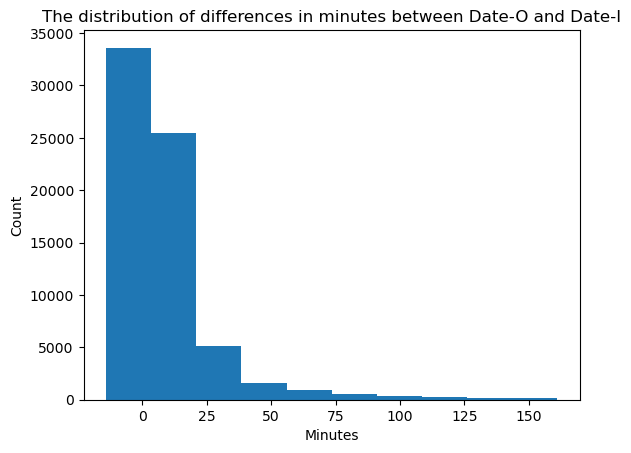

In [53]:
plt.hist(df.min_diff, bins=10)
plt.title("The distribution of differences in minutes between Date-O and Date-I")
plt.ylabel("Count")
plt.xlabel("Minutes")
plt.show()

### 3.2 Relationship between delay rate and other variables

In [91]:
## 3.2.0 The overall delay rate
print("The overall average delay rate is {}".format(df['delay_15'].sum()/df.shape[0]))

The overall average delay rate is 0.184923370242722


In [54]:
## 3.2.1 Behavior of Delay rate over destinations
### 3.2.1.1 Show the distribution of Delay rate over different destinations
dest_df = df.groupby([df['Des-I']])[['Vlo-I']].count().reset_index().rename(columns={'Des-I':'Destination Airport', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['Des-I']])[['delay_15']].sum().reset_index().rename(columns={'Des-I':'Destination Airport', 'delay_15':'Delayed Flights'})
dest_df = dest_df.join(delay_df.set_index('Destination Airport'), how="inner", on='Destination Airport')
dest_df["Delayed Ratio"] = dest_df['Delayed Flights']/dest_df['Flights']
dest_df = dest_df[['Destination Airport', "Delayed Ratio"]].sort_values(by="Delayed Ratio", ascending=False).reset_index().drop(columns=["index"])
print(tabulate(dest_df, headers = 'keys', tablefmt = 'psql'))

+----+-----------------------+-----------------+
|    | Destination Airport   |   Delayed Ratio |
|----+-----------------------+-----------------|
|  0 | EGYP                  |       1         |
|  1 | SLCB                  |       1         |
|  2 | SEQM                  |       1         |
|  3 | SAWH                  |       0.666667  |
|  4 | YSSY                  |       0.582474  |
|  5 | YMML                  |       0.552632  |
|  6 | SAZS                  |       0.5       |
|  7 | SAAR                  |       0.397059  |
|  8 | NZAA                  |       0.373961  |
|  9 | MDPC                  |       0.333333  |
| 10 | CYYZ                  |       0.314488  |
| 11 | SACO                  |       0.301075  |
| 12 | SGAS                  |       0.284483  |
| 13 | SBGL                  |       0.282427  |
| 14 | SAME                  |       0.272615  |
| 15 | SABE                  |       0.268261  |
| 16 | KMCO                  |       0.264706  |
| 17 | SANT         

In [55]:
### 3.2.1.2 Show the statistics of Delay rate over different destinations
dest_df["Delayed Ratio"].describe()

count    62.000000
mean      0.245265
std       0.215503
min       0.000000
25%       0.137332
50%       0.190316
75%       0.267372
max       1.000000
Name: Delayed Ratio, dtype: float64

In [56]:
## 3.2.2 Behavior of Delay rate over airlines
### 3.2.2.1 Show the distribution of Delay rate over different airlines
airline_df = df.groupby([df['Emp-I']])[['Vlo-I']].count().reset_index().rename(columns={'Emp-I':'Airline', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['Emp-I']])[['delay_15']].sum().reset_index().rename(columns={'Emp-I':'Airline', 'delay_15':'Delayed Flights'})
airline_df = airline_df.join(delay_df.set_index('Airline'), how="inner", on='Airline')
airline_df["Delayed Ratio"] = airline_df['Delayed Flights']/airline_df['Flights']
airline_df = airline_df[['Airline', "Delayed Ratio"]].sort_values(by="Delayed Ratio", ascending=False).reset_index().drop(columns=["index"])
print(tabulate(airline_df, headers = 'keys', tablefmt = 'psql'))


+----+-----------+-----------------+
|    | Airline   |   Delayed Ratio |
|----+-----------+-----------------|
|  0 | LNE       |       1         |
|  1 | DSM       |       1         |
|  2 | LXP       |       0.777778  |
|  3 | PUE       |       0.612245  |
|  4 | QFU       |       0.582474  |
|  5 | LPE       |       0.5       |
|  6 | ACA       |       0.456637  |
|  7 | LAW       |       0.407502  |
|  8 | JMR       |       0.39      |
|  9 | GLO       |       0.356522  |
| 10 | LAP       |       0.282407  |
| 11 | AVA       |       0.265625  |
| 12 | TAM       |       0.255822  |
| 13 | ARG       |       0.240123  |
| 14 | AUT       |       0.202703  |
| 15 | JAT       |       0.178995  |
| 16 | SKU       |       0.177582  |
| 17 | LAN       |       0.171569  |
| 18 | ONE       |       0.154122  |
| 19 | BAW       |       0.141463  |
| 20 | LRC       |       0.119565  |
| 21 | AZA       |       0.111969  |
| 22 | IBE       |       0.0994475 |
| 23 | AFR       |       0.0837989 |
|

In [57]:
### 3.2.2.2 Show the statistics of Delay rate over different Airlines
airline_df["Delayed Ratio"].describe()

count    30.000000
mean      0.297338
std       0.268321
min       0.028490
25%       0.102578
50%       0.190849
75%       0.403126
max       1.000000
Name: Delayed Ratio, dtype: float64

In [58]:
## 3.2.3 Behavior of Delay rate over month of the year
### 3.2.3.1 Show the distribution of Delay rate over month of the year
month_df = df.groupby([df['MES']])[['Vlo-I']].count().reset_index().rename(columns={'MES':'Month', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['MES']])[['delay_15']].sum().reset_index().rename(columns={'MES':'Month', 'delay_15':'Delayed Flights'})
month_df = month_df.join(delay_df.set_index('Month'), how="inner", on='Month')
month_df["Delayed Ratio"] = month_df['Delayed Flights']/month_df['Flights']
month_df = month_df[['Month', "Delayed Ratio"]].sort_values(by="Delayed Ratio", ascending=False).reset_index().drop(columns=["index"])
print(tabulate(month_df, headers = 'keys', tablefmt = 'psql'))

+----+---------+-----------------+
|    |   Month |   Delayed Ratio |
|----+---------+-----------------|
|  0 |       7 |        0.29344  |
|  1 |      12 |        0.254171 |
|  2 |      10 |        0.225833 |
|  3 |      11 |        0.197072 |
|  4 |       8 |        0.173459 |
|  5 |       9 |        0.172371 |
|  6 |       6 |        0.17105  |
|  7 |       1 |        0.15998  |
|  8 |       5 |        0.157945 |
|  9 |       2 |        0.151493 |
| 10 |       4 |        0.11658  |
| 11 |       3 |        0.115005 |
+----+---------+-----------------+


In [59]:
### 3.2.3.2 Show the statistics of Delay rate over months of the year
month_df["Delayed Ratio"].describe()

count    12.000000
mean      0.182367
std       0.052934
min       0.115005
25%       0.156332
50%       0.171710
75%       0.204262
max       0.293440
Name: Delayed Ratio, dtype: float64

In [60]:
## 3.2.4 Behavior of Delay rate over day of the week
### 3.2.4.1 Show the distribution of Delay rate over day of the week
day_df = df.groupby([df['DIANOM']])[['Vlo-I']].count().reset_index().rename(columns={'DIANOM':'Day of the week', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['DIANOM']])[['delay_15']].sum().reset_index().rename(columns={'DIANOM':'Day of the week', 'delay_15':'Delayed Flights'})
day_df = day_df.join(delay_df.set_index('Day of the week'), how="inner", on='Day of the week')
day_df["Delayed Ratio"] = day_df['Delayed Flights']/day_df['Flights']
day_df = day_df[['Day of the week', "Delayed Ratio"]].sort_values(by="Delayed Ratio", ascending=False).reset_index().drop(columns=["index"])
print(tabulate(day_df, headers = 'keys', tablefmt = 'psql'))


+----+-------------------+-----------------+
|    | Day of the week   |   Delayed Ratio |
|----+-------------------+-----------------|
|  0 | Viernes           |        0.222028 |
|  1 | Lunes             |        0.202014 |
|  2 | Jueves            |        0.199493 |
|  3 | Miercoles         |        0.17092  |
|  4 | Martes            |        0.168997 |
|  5 | Sabado            |        0.163253 |
|  6 | Domingo           |        0.161103 |
+----+-------------------+-----------------+


In [61]:
### 3.2.4.2 Show the statistics of Delay rate over day of the week
day_df["Delayed Ratio"].describe()

count    7.000000
mean     0.183972
std      0.023670
min      0.161103
25%      0.166125
50%      0.170920
75%      0.200753
max      0.222028
Name: Delayed Ratio, dtype: float64

In [62]:
## 3.2.5 Behavior of Delay rate over season
### 3.2.5.1 Show the distribution of Delay rate over season
season_df = df.groupby([df['high_season']])[['Vlo-I']].count().reset_index().rename(columns={'Vlo-I':'Flights'})
delay_df = df.groupby([df['high_season']])[['delay_15']].sum().reset_index().rename(columns={'delay_15':'Delayed Flights'})
season_df = season_df.join(delay_df.set_index('high_season'), how="inner", on='high_season')
season_df["Delayed Ratio"] = season_df['Delayed Flights']/season_df['Flights']
season_df = season_df[['high_season', "Delayed Ratio"]].sort_values(by="Delayed Ratio", ascending=False).reset_index().drop(columns=["index"])
print(tabulate(season_df, headers = 'keys', tablefmt = 'psql'))


+----+---------------+-----------------+
|    |   high_season |   Delayed Ratio |
|----+---------------+-----------------|
|  0 |             0 |        0.18758  |
|  1 |             1 |        0.179394 |
+----+---------------+-----------------+


In [63]:
## 3.2.6 Behavior of Delay rate over type of flight
### 3.2.6.1 Show the distribution of Delay rate over type of flight
type_df = df.groupby([df['TIPOVUELO']])[['Vlo-I']].count().reset_index().rename(columns={'TIPOVUELO':'Type of Flight', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['TIPOVUELO']])[['delay_15']].sum().reset_index().rename(columns={'TIPOVUELO':'Type of Flight', 'delay_15':'Delayed Flights'})
type_df = type_df.join(delay_df.set_index('Type of Flight'), how="inner", on='Type of Flight')
type_df["Delayed Ratio"] = type_df['Delayed Flights']/type_df['Flights']
type_df = type_df[['Type of Flight', "Delayed Ratio"]].sort_values(by="Delayed Ratio", ascending=False).reset_index().drop(columns=["index"])
print(tabulate(type_df, headers = 'keys', tablefmt = 'psql'))


+----+------------------+-----------------+
|    | Type of Flight   |   Delayed Ratio |
|----+------------------+-----------------|
|  0 | I                |        0.225595 |
|  1 | N                |        0.150547 |
+----+------------------+-----------------+


We finally consider Type of Flight, whether the 

## 4.0 Models
### 4.1 Training and Validation Models

In [64]:
## 4.1.1 New features based on 3.0
model_df = df.copy()

### The average delay rate in that day
model_df["Date-I"] = df['Fecha-I'].dt.date
model_df = pd.merge(model_df, date_df, how='inner', left_on=['Date-I'], 
                    right_on=['Date']).rename(columns={'Delayed Ratio':'avg_date_delay'})
model_df['avg_date_delay'] = np.where(model_df['avg_date_delay']==1, 0.99, model_df['avg_date_delay'])
model_df = model_df.drop(columns=["Date-I"])

### The average delay rate of the airline
model_df = pd.merge(model_df, airline_df, how='inner', left_on=['Emp-I'], 
                    right_on=['Airline']).rename(columns={'Delayed Ratio':'avg_airline_delay'})
model_df['avg_airline_delay'] = np.where(model_df['avg_airline_delay']==1, 0.99, model_df['avg_airline_delay'])
### The average delay rate of the destination
model_df = pd.merge(model_df, dest_df, how='inner', left_on=['Des-I'], 
                    right_on=['Destination Airport']).rename(columns={'Delayed Ratio':'avg_dest_delay'})
model_df['avg_dest_delay'] = np.where(model_df['avg_dest_delay']==1, 0.99, model_df['avg_dest_delay'])

### The binary variable to indicate whether the flight switched Airport
model_df["is_switch_airport"] = np.where(model_df["Des-O"] != model_df["Des-I"], 1, 0)

### The binary variable to indicate whether the flight switched Airline
model_df["is_switch_airline"] = np.where(model_df["Emp-O"] != model_df["Emp-I"], 1, 0)

In [65]:
### Make Month Dummies
df_month = pd.get_dummies(model_df["MES"], prefix="month")
model_df = pd.concat((model_df, df_month), axis=1)

### Make Type of Flight Dummies
df_flight = pd.get_dummies(model_df["TIPOVUELO"], prefix="type", drop_first=True)
model_df = pd.concat((model_df, df_flight), axis=1)

### Make Day of the week Dummies
df_day = pd.get_dummies(model_df["DIANOM"], prefix="day", drop_first=True)
model_df = pd.concat((model_df, df_day), axis=1)

In [67]:
### 4.1.2 Split Training, Validation and testing
X = model_df[['high_season', 'is_switch_airport', 'is_switch_airline','avg_date_delay', 'avg_airline_delay', 'avg_dest_delay']
             +list(df_flight.columns) + list(df_day.columns)]
y = model_df["delay_15"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

## 4.1.3 Model1: Logit
### 4.1.3.1 Train the model
max_roc = 0
max_precision = 0
best_feat = []
for k in range(5,13):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_train, y_train)
    cols = selector.get_support(indices=True)
    log_reg = sm.Logit(y_train, sm.add_constant(X_train.iloc[:,cols])).fit()
    y_pred = log_reg.predict(sm.add_constant(X_val.iloc[:,cols]))
    precision = average_precision_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_pred)
    if precision + roc > max_roc + max_precision:
        max_precision = precision 
        max_roc = roc
        best_model = cols

### 4.1.3.2 Best Performance on Validation Set
print("ROC AUC: {}, Average Precision Score: {}".format(max_roc, max_precision))
logit_features = X_train.iloc[:,cols].columns.tolist()
print("The best feature group is {} for logistic Regression".format(logit_features))

Optimization terminated successfully.
         Current function value: 0.436985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.436910
         Iterations 6
ROC AUC: 0.7067686587304491, Average Precision Score: 0.36215605983999516
The best feature group is ['high_season', 'is_switch_airport', 'avg_date_delay', 'avg_airline_delay', 'avg_des

In [68]:
### 4.1.3.3 The summary of Logistics Regression
log_reg = sm.Logit(y_train, sm.add_constant(X_train[logit_features])).fit()
display(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.436910
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               delay_15   No. Observations:                43638
Model:                          Logit   Df Residuals:                    43625
Method:                           MLE   Df Model:                           12
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                 0.08708
Time:                        17:53:06   Log-Likelihood:                -19066.
converged:                       True   LL-Null:                       -20884.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.1749      0.082    -50.785      0.000      -4.336      -4.014
high_season           0.0435      0.028      1.566      0.117      -0.011       0.098
is_switch_airport     0.6661      0.854      0.780      0.436      -1.008       2.340
avg_date_delay        5.9508      0.135     44.004      0.000       5.686       6.216
avg_airline_delay     3.7178      0.199     18.639      0.000       3.327       4.109
avg_dest_delay        4.3224      0.301     14.364      0.000       3.733       4.912
type_N               -0.0828      0.036     -2.305      0.021      -0.153      -0.012
day_Jueves            0.0354      0.048      0.733      0.463      -0.059       0.130
day_Lunes             0.0099      0.049      0.204      0.839      -0.085       0.105
day_Martes           -0.0158      0.050     -0.313      0.755      -0.115       0.083
day_Miercoles        -0.0444      0.050     -0.887      0.375      -0.143       0.054
day_Sabado           -0.0310      0.053     -0.589      0.556      -0.134       0.072
day_Viernes          -0.0053      0.048     -0.111      0.912      -0.100       0.089
=====================================================================================
"""

Summary.1. The summary of Best logistic Regression which we fit

In [79]:
## 4.1.4 Model2: Decision Tree
### 4.1.4.1 Split Training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

### 4.1.4.2 Train the model
max_roc = 0 
max_precision = 0
best_k = None
for k in [3, 5, 8, 10]:
    sqft_tree = tree.DecisionTreeRegressor(max_depth=k).fit(X_train,y_train)
    y_pred = sqft_tree.predict(X_val)
    precision = average_precision_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_pred)
    if precision + roc > max_roc + max_precision:
        best_k = k
        max_roc = roc
        max_precision = precision
### 4.1.4.3 Best Performance on Validation Set
print("ROC AUC: {}, Average Precision Score: {}".format(max_roc, max_precision))
print("The best max depth is {} for logistic Regression".format(best_k))

ROC AUC: 0.6969281522987342, Average Precision Score: 0.36421044050747764
The best max depth is 8 for logistic Regression


In [72]:
## 4.1.5 Model3: XGBoost
### 4.1.5.1 Train the model
max_roc = 0 
max_precision = 0
best_lr = None
best_depth = None
best_alpha = None
best_n_estimator = None
best_min_weight = None
for learning_rate in [0.1, 0.2, 0.5, 1]:
    for max_depth in [5, 10, 20]:
        for alpha in [5, 10, 15]:
            for n_estimators in [5, 12, 20]:
                for min_child_weight in [2, 5, 8, 10]:
                    xg_reg = xgb.XGBRegressor(objective ='binary:logistic', min_child_weight = min_child_weight, learning_rate = learning_rate,
                                    max_depth = max_depth, alpha = alpha, n_estimators = n_estimators)
                    xg_reg.fit(X_train,y_train)
                    preds = xg_reg.predict(X_val)
                    precision = average_precision_score(y_val, preds)
                    roc = roc_auc_score(y_val, preds)
                    if precision + roc > max_roc + max_precision:
                        best_lr = learning_rate
                        best_depth = max_depth
                        best_alpha = alpha
                        best_n_estimator = n_estimators
                        best_min_weight = min_child_weight
                        max_precision = precision 
                        max_roc = roc

### 4.1.5.2 Best Performance on Validation Set
print("ROC AUC: {}, Average Precision Score: {}".format(max_roc, max_precision))
print("The best hyperparameter for XGBoost:\nlearning_rate = {}\nmax_depth = {}\nalpha = {}\nn_estimator={}\nmin_child_weight={}\n".format(best_lr, best_depth, best_alpha, best_n_estimator, best_min_weight))

ROC AUC: 0.7156587036069835, Average Precision Score: 0.38676465856359404
The best hyperparameter for XGBoost:
 learning_rate = 0.5
 max_depth = 5
 alpha = 5
 n_estimator=20
 min_child_weight=5



### 4.2 Performance Evaluation and Discussion

In [81]:
## 4.2.1 Run the models over Test & Training dataset
### 4.2.1.1 Model1: Logistic Regression
y_pred = log_reg.predict(sm.add_constant(X_test[logit_features]))
precision = average_precision_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
y_pred = log_reg.predict(sm.add_constant(X_train[logit_features]))
tr_precision = average_precision_score(y_train, y_pred)
tr_roc = roc_auc_score(y_train, y_pred)
print("Logistic Regression: \nTest ROC-AUC: {}, Test Average Precision Score: {}\nTrain ROC-AUC: {}, Train Average Precision Score: {}".format(roc, precision, tr_roc, tr_precision))

### 4.2.1.2 Model2: Decision Tree
sqft_tree = tree.DecisionTreeRegressor(max_depth=best_k).fit(X_train,y_train)
y_pred = sqft_tree.predict(X_test)
precision = average_precision_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
y_pred = sqft_tree.predict(X_train)
tr_precision = average_precision_score(y_train, y_pred)
tr_roc = roc_auc_score(y_train, y_pred)
print("Decision Tree: \nTest ROC-AUC: {}, Test Average Precision Score: {}\nTrain ROC-AUC: {}, Train Average Precision Score: {}".format(roc, precision, tr_roc, tr_precision))

### 4.2.1.3 Model3: XGBoost
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', min_child_weight = best_min_weight, learning_rate = best_lr,
                                    max_depth = best_depth, alpha = best_alpha, n_estimators = best_n_estimator).fit(X_train,y_train)
preds = xg_reg.predict(X_test)
precision = average_precision_score(y_test, preds)
roc = roc_auc_score(y_test, preds)
y_pred = xg_reg.predict(X_train)
tr_precision = average_precision_score(y_train, y_pred)
tr_roc = roc_auc_score(y_train, y_pred)
print("XGBoost: \nTest ROC-AUC: {}, Test Average Precision Score: {}\nTrain ROC-AUC: {}, Train Average Precision Score: {}".format(roc, precision, tr_roc, tr_precision))

Logistic Regression: 
Test ROC-AUC: 0.7255567426908186, Test Average Precision Score: 0.36730348265020796
Train ROC-AUC: 0.7105875806360427, Train Average Precision Score: 0.3608604144342828
Decision Tree: 
Test ROC-AUC: 0.7218284954557719, Test Average Precision Score: 0.3702271604111833
Train ROC-AUC: 0.7301935470417645, Train Average Precision Score: 0.40584030258392456
XGBoost: 
Test ROC-AUC: 0.7306727556290499, Test Average Precision Score: 0.3844043078343973
Train ROC-AUC: 0.7335323676271093, Train Average Precision Score: 0.4044699526636135


Summary.2. The summary of performance on all three models
Based on Summary.2, all models performed well on ROC-AUC but really bad on average precision score since the positive rate of target(which is delay_15) is really low thus we determine ROC-AUC as our performance metric. In this case, the XGBoost did best over three models. Then let's check which feature is the most important.

In [98]:
feature = X_train.columns.tolist()[np.argmax(xg_reg.feature_importances_)]
print("The most influential in the prediction task is {} by feature_importances_ check in XGBoost model".format(feature))

The most influential in the prediction task is avg_date_delay by feature_importances_ check in XGBoost model


## 5.0 Conclusion